In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import xlrd

from sqlalchemy import create_engine, text, Integer, String, Column
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.ext.declarative import declarative_base
import pandas as pd

# Etapa 1 - Extração e Carregamento dos Dados

- ✅ **Escolha dos Dados**: Escolher um conjunto de dados que seja relevante para o candidato e que permita a aplicação de técnicas de análise de dados.
- ✅ **Extração**: Utilizar a linguagem de programação Python e bibliotecas como requests, pandas, sqlalchemy para extrair os dados da fonte escolhida.
- ✅ **Transformação**: Limpar e transformar os dados para garantir a qualidade e consistência.
- ❎ **Carregamento**: Carregar os dados transformados em um banco de dados relacional (PostgreSQL, MySQL, etc.), utilizando o SQLAlchemy para a conexão e inserção dos dados.


## **Escolha, Extração e Transformação dos Dados**

### Tabela 1: Projeções  FEITO

In [ ]:
# Lendo o arquivo xlsx
# Excluída as 6 primeiras linhas, visto que não são necessárias para a manipulação dos dados
projecoes_df = pd.read_excel("projecoes_2024_tab4_indicadores.xlsx", skiprows=6)

# Filtrar linhas e colunas necessárias
projecoes2_df_filtrado = projecoes_df[
    (projecoes_df["LOCAL"].str.strip() == "Brasil") &                                                     # LOCAL == "Brasil" 
    (projecoes_df["ANO"].astype(float).between(2018, 2024) | (projecoes_df["ANO"].astype(float) == 2045)) # ANO no intervalo [2018, 2025] ou [2045]
]

# Selecionar apenas as colunas desejadas
colunas_desejadas = ["ANO", "LOCAL", "POP_T", "POP_H", "POP_M", "e0_T", "e60_T"]
projecoes2_df_filtrado = projecoes2_df_filtrado[colunas_desejadas]

projecoes2_df_filtrado

,ANO,LOCAL,POP_T,POP_H,POP_M,e0_T,e60_T
18,2018,Brasil,206529038,100895555,105633483,75.990227,22.206781
19,2019,Brasil,207900099,101551234,106348865,76.221101,22.254800
20,2020,Brasil,209164889,102140954,107023935,74.809005,21.169615
21,2021,Brasil,210103642,102550853,107552789,72.784302,20.084039
22,2022,Brasil,210862983,102875114,107987869,75.448044,21.619386
23,2023,Brasil,211695158,103251553,108443605,76.388455,22.470774
24,2024,Brasil,212583750,103662286,108921464,76.605711,22.590940
45,2045,Brasil,220045691,106861156,113184535,80.540082,24.724144


### Tabela 2: Perfil etário  FEITO

In [26]:
# Lendo o arquivo xls
# Excluída as 2 primeiras linhas, visto que não são necessárias para a manipulação dos dados
etario18_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2018", skiprows=2)
socio19_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2019", skiprows=2)
etario20_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2020", skiprows=2)
etario21_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2021", skiprows=2)
etario22_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2022", skiprows=2)
etario23_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2023", skiprows=2)

#Retirar linhas 4:8
# Separar em subconjuntos
## Total          [9:16]
## Homens         [18:25]
## Mulheres       [27:34]
## Branca         [36:43]
## Preta ou parda [45:52]

def processar_etario(df):
    
    # Separar em subconjuntos
    total_df = df.iloc[9-4:17-4]  # Total [9:16]
    homens_df = df.iloc[18-4:26-4]  # Homens [18:25]
    mulheres_df = df.iloc[27-4:35-4]  # Mulheres [27:34]
    branca_df = df.iloc[36-4:44-4]  # Branca [36:43]
    preta_parda_df = df.iloc[45-4:53-4]  # Preta ou parda [45:52]
    
    # Retornar os subconjuntos como um dicionário (para fácil acesso)
    return {
        'total': total_df,
        'homens': homens_df,
        'mulheres': mulheres_df,
        'branca': branca_df,
        'preta_parda': preta_parda_df
    }

# Exemplo de uso para os DataFrames etario18_df, etario19_df, etc.

# Lista com os DataFrames
dataframes = [etario18_df, socio19_df, etario20_df, etario21_df, etario22_df, etario23_df]

# Dicionário para armazenar os subconjuntos de cada DataFrame
resultados = {}

for i, df in enumerate(dataframes, start=18):
    # Processar o DataFrame atual
    subconjuntos = processar_etario(df)
    
    # Armazenar os subconjuntos no dicionário
    resultados[f'etario{i}_df'] = subconjuntos

# Exibindo os subconjuntos (opcional)
resultados['etario18_df']['total']

,Características selecionadas,População em idade de trabalhar\n(1 000 pessoas),População na força de trabalho\n(1 000 pessoas),População ocupada\n(1 000 pessoas),População ocupada em trabalhos formais (1)\n(1 000 pessoas),População desocupada\n(1 000 pessoas),População na força de trabalho potencial\n(1 000 pessoas),População subutilizada\n(1 000 pessoas),Taxa de participação (%),Nível de ocupação (%),Taxa de formalização (%),Taxa de desocupação (%),Taxa composta de subutilização (%)
5,Total,166576.290000,105621.988924,92771.358454,54504.240877,12850.630470,8261.794278,28082.380141,63.407577,55.693015,58.751151,12.166624,24.658805
6,14 a 29 anos,53740.326000,33132.426747,25979.633050,14100.904491,7152.793698,4218.245386,13949.089745,61.652821,48.342902,54.276765,21.588499,37.346288
7,14 a 17 anos,12725.532534,2629.720177,1542.513321,256.198641,1087.206856,1383.021304,2717.897205,20.664913,12.121405,16.609169,41.343062,67.731680
8,18 a 24 anos,23998.725466,16643.339318,12473.456902,6537.316358,4169.882416,1995.873394,7444.903613,69.350930,51.975497,52.409820,25.054362,39.942157
9,25 a 29 anos,17016.068000,13859.367252,11963.662826,7307.389492,1895.704426,839.350688,3786.288927,81.448706,70.308034,61.079868,13.678146,25.759314
10,30 a 49 anos,61927.785000,50663.517137,46204.833890,29209.662735,4458.683248,2528.359174,10196.632347,81.810640,74.610829,63.217764,8.800580,19.169529
11,50 a 59 anos,22969.121000,15169.794455,14193.313993,8442.740080,976.480461,835.176388,2650.769400,66.044297,61.793022,59.483924,6.437005,16.562163
12,60 anos ou mais,27939.058000,6656.250586,6393.577522,2750.933571,262.673064,680.013330,1285.888649,23.824177,22.884012,43.026515,3.946262,17.527841


### Tabela 3: Perfil socio/econômico FEITO

In [25]:
# Lendo o arquivo xls
# Excluída as 2 primeiras linhas, visto que não são necessárias para a manipulação dos dados
socio18_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2018", skiprows=2)
socio19_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2019", skiprows=2)
socio20_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2020", skiprows=2)
socio21_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2021", skiprows=2)
socio22_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2022", skiprows=2)
socio23_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2023", skiprows=2)

def processar_socio(df):
    
    # Separar em subconjuntos
    total_df = df.iloc[55-4:60-4]  # Total [55:59]
    homens_df = df.iloc[61-4:66-4]  # Homens [61:65]
    mulheres_df = df.iloc[67-4:72-4]  # Mulheres [67:71]
    branca_df = df.iloc[73-4:78-4]  # Branca [73:77]
    preta_parda_df = df.iloc[79-4:84-4]  # Preta ou parda [79:83]
    
    # Retornar os subconjuntos como um dicionário (para fácil acesso)
    return {
        'total': total_df,
        'homens': homens_df,
        'mulheres': mulheres_df,
        'branca': branca_df,
        'preta_parda': preta_parda_df
    }

# Lista com os DataFrames
dataframes = [socio18_df, socio19_df, socio20_df, socio21_df, socio22_df, socio23_df]

# Dicionário para armazenar os subconjuntos de cada DataFrame
resultados = {}

for i, df in enumerate(dataframes, start=18):
    # Processar o DataFrame atual
    subconjuntos = processar_socio(df)
    
    # Armazenar os subconjuntos no dicionário
    resultados[f'socio{i}_df'] = subconjuntos

# # Exibindo os subconjuntos (opcional)
resultados['socio18_df']['total']

,Características selecionadas,População em idade de trabalhar\n(1 000 pessoas),População na força de trabalho\n(1 000 pessoas),População ocupada\n(1 000 pessoas),População ocupada em trabalhos formais (1)\n(1 000 pessoas),População desocupada\n(1 000 pessoas),População na força de trabalho potencial\n(1 000 pessoas),População subutilizada\n(1 000 pessoas),Taxa de participação (%),Nível de ocupação (%),Taxa de formalização (%),Taxa de desocupação (%),Taxa composta de subutilização (%)
51,Total,166576.290000,105621.988924,92771.358454,54504.240877,12850.630470,8261.794278,28082.380141,63.407577,55.693015,58.751151,12.166624,24.658805
52,Sem instrução ou fundamental incompleto,58402.318920,26782.175393,23681.469242,9093.344674,3100.706151,3458.114658,9052.904336,45.858068,40.548851,38.398566,11.577499,29.936566
53,Ensino fundamental completo ou médio incompleto,29029.255342,17053.798518,14207.574577,7083.307005,2846.223940,2029.636246,6151.606576,58.746938,48.942263,49.855850,16.689677,32.235322
54,Ensino médio completo ou superior incompleto,55822.330986,42356.954721,36629.671612,24104.610580,5727.283110,2329.847983,10365.597137,75.878155,65.618313,65.806243,13.521470,23.196104
55,Ensino superior completo,23322.384752,19429.060293,18252.643024,14222.978619,1176.417269,444.195391,2512.272092,83.306491,78.262336,77.922844,6.054937,12.641472


## **Carregamento**  TERMINAR

In [ ]:
# Defina as credenciais do MySQL
user = "root"
password = "admin"
host = "0.0.0.0"  # ou IP do servidor
database_name = "projecoes2_banco"

# Crie a engine de conexão sem especificar um banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}")

# Crie a base para definir as tabelas
Base = declarative_base()

# Defina a tabela com chave primária
class Projecao(Base):
    __tablename__ = "projecoes2_table"
    
    ano = Column(Integer, primary_key=True)  # Definindo a chave primária
    local = Column(String(50))
    pop_t = Column(Integer)
    pop_h = Column(Integer)
    pop_m = Column(Integer)
    e0_t = Column(Integer)
    e60_t = Column(Integer)

# Crie o banco de dados se não existir
try:
    with engine.connect() as connection:
        connection.execute(text(f"CREATE DATABASE IF NOT EXISTS {database_name};"))
        print(f"Banco de dados '{database_name}' criado com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar o banco de dados: {e}")

# Criar a tabela dentro do banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database_name}")

try:
    Base.metadata.create_all(engine)  # Criação da tabela
    print("Tabela 'projecoes2_table' criada com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar a tabela: {e}")

# Inserir os dados do DataFrame na tabela
try:
    # A variável projecoes2_df_filtrado deve ser um DataFrame pandas
    projecoes2_df_filtrado.to_sql('projecoes2_table', con=engine, if_exists='append', index=False)
    print("Dados inseridos com sucesso na tabela 'projecoes2_table'!")
except SQLAlchemyError as e:
    print(f"Erro ao inserir os dados: {e}")


Banco de dados 'projecoes2_banco' criado com sucesso!
Tabela 'projecoes2_table' criada com sucesso!
Dados inseridos com sucesso na tabela 'projecoes2_table'!


# Etapa 2 - Modelagem dos Dados com DBT
- **Criação do Projeto**: Criar um projeto DBT e conectar ao banco de dados criado na etapa anterior.
- **Modelagem**: Criar modelos DBT para transformar os dados brutos em um modelo dimensional, com tabelas ou views.
- **Cálculos**: Realizar cálculos de agregação, criar views e tabelas intermediárias para preparar os dados para a geração de relatórios.
- **Documentação**: Documentar os modelos DBT utilizando a linguagem YAML, explicando a lógica de cada modelo.


# Etapa 3: Criação de um Relatório ou Dashboard (Opcional)

- **Escolha da Ferramenta**: Utilizar uma ferramenta de BI (Business Intelligence) como Tableau, Power BI ou uma biblioteca de visualização em Python (matplotlib, seaborn) para criar um relatório ou dashboard.
- **Visualização**: Criar visualizações que respondam a perguntas de negócio relevantes e que permitam uma fácil interpretação dos dados.


### Tabela 1: Projeções FEITO

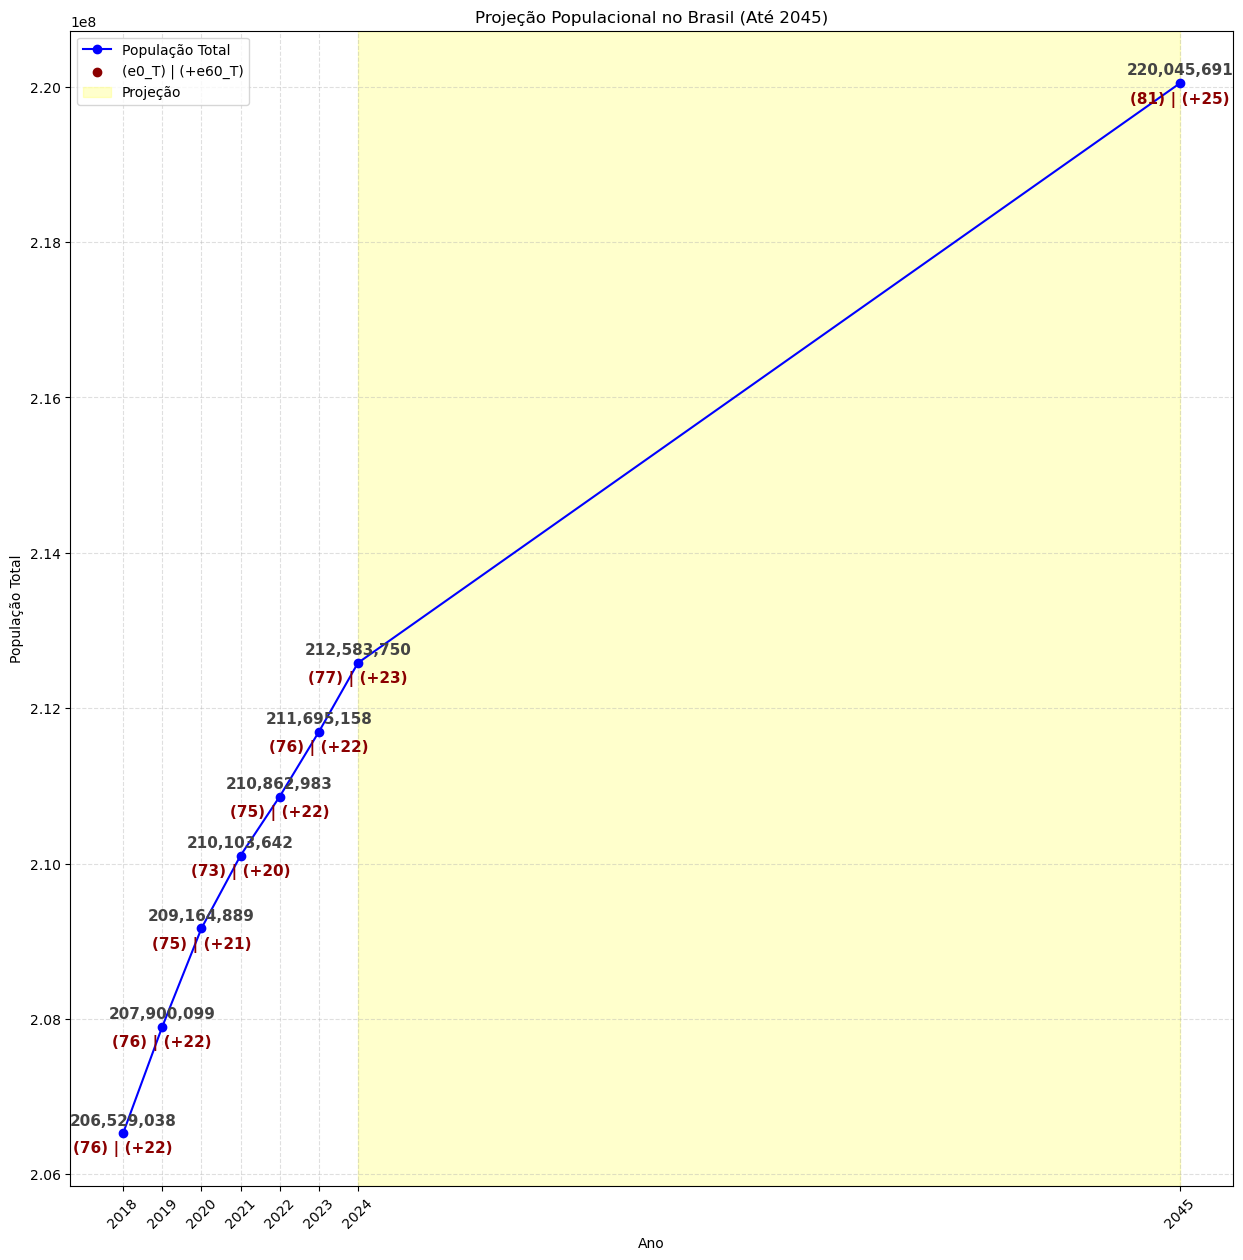

In [14]:
import matplotlib.pyplot as plt

# Criar o gráfico principal
plt.figure(figsize=(15, 15))
plt.plot(projecoes2_df_filtrado["ANO"], projecoes2_df_filtrado["POP_T"],
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["ANO"], 
                                 projecoes2_df_filtrado["POP_T"], 
                                 projecoes2_df_filtrado["e0_T"], 
                                 projecoes2_df_filtrado["e60_T"]):
    plt.text(ano, pop + (pop * 0.0005), f"{pop:,.0f}", 
             ha="center", fontsize=11, color="#444444", fontweight="bold")

    plt.text(ano, pop - (pop * 0.0012), f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="center", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["ANO"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()


### Tabela 2: Perfil etário TERMINAR

In [ ]:
import matplotlib.pyplot as plt

# Criar o gráfico principal
plt.figure(figsize=(15, 15))
plt.plot(projecoes2_df_filtrado["ANO"], projecoes2_df_filtrado["POP_T"],
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["ANO"], 
                                 projecoes2_df_filtrado["POP_T"], 
                                 projecoes2_df_filtrado["e0_T"], 
                                 projecoes2_df_filtrado["e60_T"]):
    plt.text(ano, pop + (pop * 0.0005), f"{pop:,.0f}", 
             ha="center", fontsize=11, color="#444444", fontweight="bold")

    plt.text(ano, pop - (pop * 0.0012), f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="center", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["ANO"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()


### Tabela 3: Perfil socio/econômico TERMINAR

In [ ]:
import matplotlib.pyplot as plt

# Criar o gráfico principal
plt.figure(figsize=(15, 15))
plt.plot(projecoes2_df_filtrado["ANO"], projecoes2_df_filtrado["POP_T"],
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["ANO"], 
                                 projecoes2_df_filtrado["POP_T"], 
                                 projecoes2_df_filtrado["e0_T"], 
                                 projecoes2_df_filtrado["e60_T"]):
    plt.text(ano, pop + (pop * 0.0005), f"{pop:,.0f}", 
             ha="center", fontsize=11, color="#444444", fontweight="bold")

    plt.text(ano, pop - (pop * 0.0012), f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="center", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["ANO"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()
